In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as pnp

## 3.0 Gerar Dados (Opcional)

Executar esta célula apenas se ainda não tiver os dados do notebook anterior

Gera um pequeno dataset mock usando `make_moons` do scikit-learn.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

os.makedirs('../data', exist_ok=True)

X, y = make_moons(n_samples=20, noise=0.1, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

np.save('../data/X_train.npy', X_train)
np.save('../data/X_test.npy', X_test)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

## 3.1 Carregar Dados do Bloco Anterior

In [2]:
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

# Converter labels para {-1, +1}
y_train_quantum = 2 * y_train - 1
y_test_quantum = 2 * y_test - 1

In [3]:
# Shapes
print(f"Shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}\n")

# Primeiras amostras
print(f"{'':>3} {'Feature 1':>10} {'Feature 2':>10} {'Label':>6} {'Quantum':>8}")
print("-" * 42)
for i in range(min(5, len(X_train))):
    print(f"{i:>3} {X_train[i, 0]:>10.4f} {X_train[i, 1]:>10.4f} {y_train[i]:>6} {y_train_quantum[i]:>8}")

Shapes:
   X_train: (14, 2)
   X_test:  (6, 2)

     Feature 1  Feature 2  Label  Quantum
------------------------------------------
  0     0.2855     0.8336      0       -1
  1     0.3569     0.4470      0       -1
  2     0.4601    -1.5363      1        1
  3    -1.3954     0.8231      0       -1
  4     1.6799     0.7767      1        1


### Por que {-1, +1}?



**Razões para converter labels de {0, 1} para {-1, +1}:**

1. **Alinhamento com expectation values**
   - PauliZ retorna naturalmente valores em [-1, 1]
   - Não precisamos de função de ativação adicional
   
2. **Facilita interpretação**
   - Saída positiva → classe 1
   - Saída negativa → classe 0
   - Magnitude indica confiança
   
3. **Melhor comportamento do gradiente**
   - Labels {-1, +1} são simétricos em torno de zero
   - Gradientes ficam mais balanceados
   
4. **Compatibilidade com funções de loss**
   - MSE funciona melhor com targets simétricos
   - Alternativa: hinge loss, que também usa {-1, +1}

## 3.2 Configuração do Quantum Device

In [4]:
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

## 3.3 Definição do QNode

O QNode conecta o circuito quântico ao framework de otimização.

In [ ]:
def angle_embedding(x, wires):
    """
    Embeds classical data into quantum state using angle encoding.
    Maps each feature to a rotation on a qubit.
    
    Args:
        x: Input data point 
        wires: Qubits to encode into
    """
    for i, wire in enumerate(wires):
        qml.RY(x[i], wires=wire)

def variational_circuit(params, x):
    """
    Complete variational quantum circuit with embedding + parametrized layers.
    
    Architecture:
    1. Angle embedding: encode classical data
    2. Variational layers: trainable rotations + entanglement
    
    Args:
        params: Trainable parameters (shape: [n_layers, n_qubits, 3])
        x: Input data point
    """
    n_layers = params.shape[0]
    for layer in range(n_layers):
        # Parametrized rotations on each qubit
        for i in range(n_qubits):
            qml.Rot(params[layer, i, 0], params[layer, i, 1], params[layer, i, 2], wires=i)
        
        # Entanglement: CNOT gate creates correlations between qubits (entrelaçamento circular)
        if n_qubits==2:
            qml.CNOT(wires=[0,1])
        elif n_qubits>2:
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i+1) % n_qubits])

# Criar QNode: conecta circuito quântico ao framework de otimização
@qml.qnode(dev, diff_method='parameter-shift')
def quantum_circuit(params, x):
    """
    Complete quantum circuit with embedding + variational layers.
    
    Args:
        params: Circuit parameters (trainable)
        x: Input data point
    
    Returns:
        Expectation value of PauliZ on first qubit ∈ [-1, 1]
    """
    angle_embedding(x, wires=range(n_qubits))
    variational_circuit(params, x)
    return qml.expval(qml.PauliZ(0))

### Como funciona o QNode?

**Pipeline do QNode:**

1. **Input clássico** → Recebe `x` (features) e `params` (pesos treináveis)
2. **Angle Embedding** → Codifica `x` em rotações: cada feature vira um ângulo RY
3. **Variational Layers** → Aplica rotações parametrizadas (Rot gates) + entanglement (CNOT)
4. **Measurement** → Mede PauliZ no primeiro qubit
5. **Output** → Retorna expectation value ∈ [-1, 1]

**Por que PauliZ?**
- PauliZ mede probabilidade de estado |0⟩ vs |1⟩
- Retorna valores em [-1, +1], perfeito para classificação binária
- +1 indica classe positiva, -1 indica classe negativa

**Diferencial do QNode:**
- `diff_method='parameter-shift'` → PennyLane calcula gradientes quanticamente
- Permite treinar circuito como uma rede neural clássica

## 3.4 Função de Previsão

In [6]:
def predict(params, x):
    """
    Predict class label for input x.
    
    Args:
        params: Circuit parameters
        x: Input data point
    
    Returns:
        Predicted label: -1 or +1
    """
    prediction = quantum_circuit(params, x)
    return np.sign(prediction)

## 3.5 Loss Function: MSE

In [7]:
def loss_function(params, X, y):
    """
    Mean Squared Error loss.
    
    Args:
        params: Circuit parameters
        X: Input data batch
        y: True labels (in {-1, +1})
    
    Returns:
        MSE loss
    """
    predictions = pnp.stack([quantum_circuit(params, x) for x in X])
    loss = pnp.mean((predictions - y) ** 2)
    return loss

### Por que MSE?



**Vantagens do Mean Squared Error para QML:**

1. **Função diferenciável** → Gradientes bem definidos em todo o domínio
2. **Funciona bem com expectation values** → Saídas contínuas em [-1, 1]
3. **Simples e eficiente** → Menos custo computacional que outras losses
4. **Penaliza erros grandes** → Quadrado amplifica desvios significativos

**Outras opções:**
- **Hinge loss**: Usado em SVMs, também funciona com {-1, +1}
- **Cross-entropy**: Requer conversão para probabilidades [0, 1]
- **Absolute loss**: Menos sensível a outliers, mas gradiente constante

Para este projeto, MSE é ideal porque:
- O dataset é pequeno (sem outliers extremos)
- Queremos treinar rápido (demo)
- Gradientes informativos ajudam convergência

## 3.6 Quantum Gradients: Parameter-Shift

Demonstração de como o PennyLane calcula gradientes quânticos.

In [8]:
dummy_params = pnp.random.random((2, 2, 3), requires_grad=True)
dummy_x = X_train[0]
dummy_y = y_train_quantum[0]

# Calcular gradiente
grad = qml.grad(lambda p: loss_function(p, [dummy_x], [dummy_y]))
gradient = grad(dummy_params)
print(f"Gradient shape: {gradient.shape}")
print(f"Gradient (sample): {gradient[0, 0, :]}")

Gradient shape: (2, 2, 3)
Gradient (sample): [ 0.16750985 -0.4636763   0.24320769]


### Como funciona o Parameter-Shift Rule?



**O PennyLane usa parameter-shift automaticamente para calcular gradientes quânticos!**

**Problema:** Não podemos usar backpropagation clássica em circuitos quânticos reais.

**Solução:** Parameter-shift rule - uma técnica quântica para calcular derivadas.

**Como funciona:**

Para calcular ∂f/∂θ, onde f é a função de custo e θ é um parâmetro do circuito:

$$\frac{\partial f}{\partial \theta} = \frac{f(\theta + \pi/2) - f(\theta - \pi/2)}{2}$$

**Passo a passo:**
1. Avalia o circuito com θ + π/2 → resultado R₁
2. Avalia o circuito com θ - π/2 → resultado R₂  
3. Gradiente = (R₁ - R₂) / 2

**Vantagens:**
- Funciona em hardware quântico real
- Exato (não aproximado)

**Custo:** Cada gradiente requer 2 avaliações do circuito (vs 1 em backprop clássica)

## 3.7 Loop de Treinamento

In [9]:
n_layers = 2
n_epochs = 100
learning_rate = 0.1
batch_size = 10

# Inicializar parâmetros
params = pnp.random.random((n_layers, n_qubits, 3), requires_grad=True)

# Otimizador
opt = qml.GradientDescentOptimizer(stepsize=learning_rate)


initial_loss = loss_function(params, X_train, y_train_quantum)
loss_history = [initial_loss]  
print(f"Initial loss: {initial_loss:.4f}")

Initial loss: 1.6147


In [10]:
for epoch in range(n_epochs):
    # Shuffle dados
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train_quantum[indices]
    
    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        
        params = opt.step(lambda p: loss_function(p, X_batch, y_batch), params)
    
    # Calcular loss da época
    current_loss = loss_function(params, X_train, y_train_quantum)
    loss_history.append(current_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {current_loss:.4f}")

Epoch 10/100 - Loss: 0.2476
Epoch 20/100 - Loss: 0.2202
Epoch 20/100 - Loss: 0.2202
Epoch 30/100 - Loss: 0.2182
Epoch 30/100 - Loss: 0.2182
Epoch 40/100 - Loss: 0.2149
Epoch 40/100 - Loss: 0.2149
Epoch 50/100 - Loss: 0.2148
Epoch 50/100 - Loss: 0.2148
Epoch 60/100 - Loss: 0.2163
Epoch 60/100 - Loss: 0.2163
Epoch 70/100 - Loss: 0.2156
Epoch 70/100 - Loss: 0.2156
Epoch 80/100 - Loss: 0.2140
Epoch 80/100 - Loss: 0.2140
Epoch 90/100 - Loss: 0.2149
Epoch 90/100 - Loss: 0.2149
Epoch 100/100 - Loss: 0.2155
Epoch 100/100 - Loss: 0.2155


## 3.8 Visualização do Treinamento

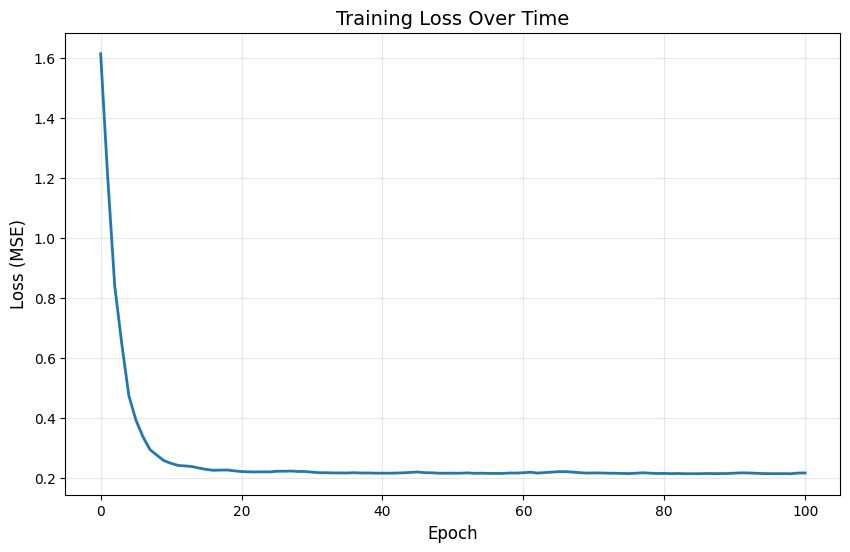

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

## 3.9 Avaliar e Salvar Modelo Treinado

### 3.9.1 Avaliação Rápida

Avaliação simples para verificar se o modelo está aprendendo.

In [12]:
# Avaliar acurácia no conjunto de treino
train_predictions = [predict(params, x) for x in X_train]
train_accuracy = np.mean([pred == true for pred, true in zip(train_predictions, y_train_quantum)])

# Avaliar acurácia no conjunto de teste
test_predictions = [predict(params, x) for x in X_test]
test_accuracy = np.mean([pred == true for pred, true in zip(test_predictions, y_test_quantum)])

print("=== Resultados do Treinamento ===")
print(f"Dataset: {len(X_train)} treino, {len(X_test)} teste")
print(f"Acurácia Treino: {train_accuracy*100:.1f}%")
print(f"Acurácia Teste: {test_accuracy*100:.1f}%")
print(f"Loss Final: {loss_history[-1]:.4f}")

=== Resultados do Treinamento ===
Dataset: 14 treino, 6 teste
Acurácia Treino: 92.9%
Acurácia Teste: 66.7%
Loss Final: 0.2155


### 3.9.2 Salvar Modelo Treinado

In [13]:
np.save('../results/trained_params.npy', params)
np.save('../results/loss_history.npy', loss_history)
print(f"Parâmetros salvos em: ../results/trained_params.npy")
print(f"Histórico de loss salvo em: ../results/loss_history.npy")

Parâmetros salvos em: ../results/trained_params.npy
Histórico de loss salvo em: ../results/loss_history.npy


## 3.10 Conceitos Avançados: Jacobians e Derivadas de Alta Ordem

### Por que isso importa?

Além dos gradientes básicos (primeira derivada), a otimização quântica pode se beneficiar de:
- **Jacobians**: Todas as derivadas parciais simultaneamente
- **Hessians**: Segunda derivada (curvatura da função de custo)
- **Quantum Fisher Information**: Medida de "informação" sobre parâmetros

Esses conceitos são fundamentais para otimizadores avançados e análise de convergência.

### 3.10.1 Jacobian de Circuitos Quânticos

O **Jacobian** é a matriz de todas as derivadas parciais de um circuito:

$$J_{ij} = \frac{\partial f_i}{\partial \theta_j}$$

onde:
- $f_i$ são as saídas do circuito (expectation values)
- $\theta_j$ são os parâmetros treináveis

**No PennyLane:**
```python
# PennyLane pode calcular o Jacobian completo automaticamente
jacobian_fn = qml.jacobian(quantum_circuit)
J = jacobian_fn(params, x)  # Matriz de derivadas
```

**Para que serve?**
- Entender sensibilidade de TODAS as saídas a TODOS os parâmetros
- Otimizadores como BFGS usam essa informação
- Análise de barren plateaus (gradientes que desaparecem)

In [16]:
# Demonstração: Calcular Jacobian do nosso circuito
print("=== Demonstração de Jacobian ===\n")

# Para demonstrar Jacobian, usamos a função de loss (uma saída escalar)
# mas podemos calcular o gradiente em relação a todos os parâmetros
demo_params = pnp.array([[[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]],
                          [[0.7, 0.8, 0.9], [1.0, 1.1, 1.2]]], requires_grad=True)
demo_x = X_train[0]
demo_y = y_train_quantum[0]

# Calcular Jacobian (gradiente de cada parâmetro)
grad_fn = qml.grad(lambda p: quantum_circuit(p, demo_x))
jacobian = grad_fn(demo_params)

print(f"Forma do Jacobian: {jacobian.shape}")
print(f"Interpretação: (2 layers × 2 qubits × 3 ângulos) = 12 parâmetros")
print(f"\nJacobian (primeiros valores):")
print(f"{jacobian[0, :, :]}\n")
print("Cada elemento mostra quanto a saída muda com cada parâmetro.")
print("Valores grandes → parâmetro tem alta influência")
print("Valores pequenos → parâmetro tem baixa influência (possível barren plateau)")

=== Demonstração de Jacobian ===

Forma do Jacobian: (2, 2, 3)
Interpretação: (2 layers × 2 qubits × 3 ângulos) = 12 parâmetros

Jacobian (primeiros valores):
[[ 0.11126308 -0.52889642  0.17419717]
 [ 0.09700604 -0.03546267  0.12379182]]

Cada elemento mostra quanto a saída muda com cada parâmetro.
Valores grandes → parâmetro tem alta influência
Valores pequenos → parâmetro tem baixa influência (possível barren plateau)


### 3.10.2 Derivadas de Segunda Ordem (Hessian)

A **Hessian** é a matriz de segundas derivadas:

$$H_{ij} = \frac{\partial^2 f}{\partial \theta_i \partial \theta_j}$$

**Por que isso importa?**
- Mostra a **curvatura** da função de custo
- Otimizadores de segunda ordem (Newton, BFGS) usam Hessian
- Ajuda a identificar mínimos locais vs pontos de sela
- Analisa **barren plateaus** (quando Hessian → 0)

**No PennyLane:**
```python
# Calcular Hessian automaticamente
hessian_fn = qml.jacobian(qml.grad(loss_function))
H = hessian_fn(params, X_batch, y_batch)
```

**Custo computacional:**
- Gradiente: O(N) avaliações (N = número de parâmetros)
- Hessian: O(N²) avaliações
- Por isso, raramente usado em treino, mais para análise

### 3.10.3 Quantum Fisher Information (QFI)

A **Quantum Fisher Information Matrix** mede quanta "informação" sobre os parâmetros pode ser extraída do estado quântico.

**Definição:**

$$F_{ij} = 4 \text{Re}[\langle \partial_i \psi | \partial_j \psi \rangle - \langle \partial_i \psi | \psi \rangle \langle \psi | \partial_j \psi \rangle]$$

onde $|\psi\rangle$ é o estado quântico e $\partial_i = \frac{\partial}{\partial \theta_i}$

**Interpretação física:**
- QFI mede quão "distinguíveis" são estados vizinhos no espaço de parâmetros
- Relacionado à **sensibilidade quântica** do circuito
- Limite superior para gradientes: $|\nabla f| \leq \text{QFI}$

**Aplicações em QML:**

1. **Detecção de Barren Plateaus**
   - Se QFI → 0, gradientes desaparecem
   - Indica que parâmetros não afetam o estado quântico
   
2. **Quantum Natural Gradient**
   - Usa QFI como métrica para otimização
   - Análogo ao "natural gradient" em ML clássico
   - Melhora convergência em paisagens complexas

3. **Escolha de Ansatz**
   - Ansatz com QFI alto → mais expressivo
   - Ansatz com QFI baixo → risco de barren plateau

In [18]:
# Demonstração: Quantum Fisher Information
print("=== Demonstração de QFI ===\n")

# Usar um subset pequeno de parâmetros para visualização
small_params = pnp.array([0.5, 0.3], requires_grad=True)

# Criar circuito simples para QFI
@qml.qnode(dev, diff_method='parameter-shift')
def simple_circuit(params):
    qml.RY(params[0], wires=0)
    qml.RX(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

# Calcular QFI (métrica para quantum natural gradient)
qfi_fn = qml.metric_tensor(simple_circuit, approx='block-diag')
qfi_matrix = qfi_fn(small_params)

print(f"QFI Matrix shape: {qfi_matrix.shape}")
print(f"QFI Matrix:\n{qfi_matrix}")
print(f"\nInterpretação:")
print(f"- Valores altos na diagonal: parâmetro tem alta sensibilidade")
print(f"  QFI[0,0] = {qfi_matrix[0,0]:.4f} (sensibilidade do parâmetro 0)")
print(f"  QFI[1,1] = {qfi_matrix[1,1]:.4f} (sensibilidade do parâmetro 1)")
print(f"- Valores baixos: parâmetro tem pouca influência (risco de barren plateau)")
print(f"- Valores off-diagonal: correlação entre parâmetros")
print(f"  QFI[0,1] = {qfi_matrix[0,1]:.4f} (correlação entre parâmetros 0 e 1)")

=== Demonstração de QFI ===

QFI Matrix shape: (2, 2)
QFI Matrix:
[[0.25       0.        ]
 [0.         0.19253779]]

Interpretação:
- Valores altos na diagonal: parâmetro tem alta sensibilidade
  QFI[0,0] = 0.2500 (sensibilidade do parâmetro 0)
  QFI[1,1] = 0.1925 (sensibilidade do parâmetro 1)
- Valores baixos: parâmetro tem pouca influência (risco de barren plateau)
- Valores off-diagonal: correlação entre parâmetros
  QFI[0,1] = 0.0000 (correlação entre parâmetros 0 e 1)


### 3.10.4 Resumo: Hierarquia de Derivadas em QML

| Conceito | O que calcula | Quando usar | Custo |
|----------|---------------|-------------|-------|
| **Gradiente** (∇f) | Primeira derivada | Otimização básica (SGD, Adam) | O(N) |
| **Jacobian** (J) | Todas derivadas parciais | Múltiplas saídas, análise de sensibilidade | O(N×M) |
| **Hessian** (H) | Segunda derivada | Otimizadores avançados, análise de curvatura | O(N²) |
| **QFI** (F) | Informação quântica | Natural gradient, detecção de barren plateaus | O(N²) |

**Para este projeto:**
- Usamos apenas **gradientes** (parameter-shift rule)
- Suficiente para gradient descent
- Conceitos avançados são úteis para pesquisa e otimização em larga escala

**Referências:**
- [PennyLane Codebook: Circuit Optimization](https://pennylane.ai/codebook/pennylane-fundamentals/circuit-optimization)
- [Quantum Natural Gradient](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html)
- [Barren Plateaus in QML](https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html)